In [125]:
from StepperController import StepperController
import cv2 as cv
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

### PLACE THE SAUSAGE IN INITIAL POSITION
**Flat part of the ring to the top**

In [126]:
DATA_PATH = "../data"
ROTATION_COUNT = 16
DEGREE_PER_IMAGE = 1
IMAGE_SIZE = 640
CROP_SIZE = 224
SAUSAGE_RATIO = 60/12
YOLO_CONFIDENCE = 0.5

In [127]:
controller = StepperController('/dev/tty.usbserial-2130')
yolo_model = YOLO('../weights/yolo11n_trained.pt')
cap = cv.VideoCapture(0)
cap.set(cv.CAP_PROP_FRAME_WIDTH, 4000)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, 2000)

Connected to Arduino on /dev/tty.usbserial-2130


True

In [128]:
def process_frame(frame, yolo_model):
    w, h = frame.shape[1], frame.shape[0]
    image = frame[h//2 - IMAGE_SIZE//2:h//2 + IMAGE_SIZE//2, w//2 - IMAGE_SIZE//2:w//2 + IMAGE_SIZE//2]
    results = yolo_model(image, verbose=False)
    detections = results[0]  # Extract detections

    if len(detections) == 0:
        return None
    
    det = detections[0]

    max_conf = 0
    for i in range(len(det.boxes)):
        conf = det.boxes.conf[i].item()
        if conf > max_conf:
            max_conf = conf
            det = detections[i]

    if max_conf < YOLO_CONFIDENCE:  # Confidence threshold
        return None
    
    x1, y1, x2, y2 = det.boxes.xyxy[0].tolist()
    conf = det.boxes.conf[0].item()
    
    # Crop the detected region
    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
    x_center = (x1 + x2) // 2
    y_center = (y1 + y2) // 2
    x1 = max(0, x_center - CROP_SIZE // 4)
    y1 = max(0, y_center - CROP_SIZE // 2)
    x2 = min(image.shape[1], x_center + CROP_SIZE // 4)
    y2 = min(image.shape[0], y_center + CROP_SIZE // 2)

    cropped = image[y1:y2, x1:x2]

    return cropped

### Test frame reading to set up bounding boxes

Frame size: 2592x1944


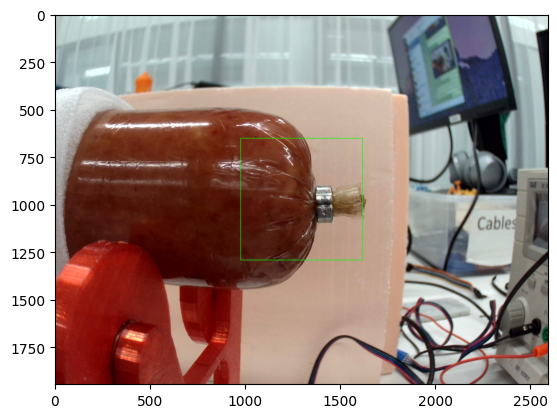

In [133]:
ret, frame = cap.read()
if not ret:
    print("Error: Could not read frame from webcam.")
w, h = frame.shape[1], frame.shape[0]
print(f"Frame size: {w}x{h}")
image = cv.rectangle(frame, (w//2 - IMAGE_SIZE//2, h//2 - IMAGE_SIZE//2), (w//2 + IMAGE_SIZE//2, h//2 + IMAGE_SIZE//2), (0, 255, 0), 2)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

### Test ring detection

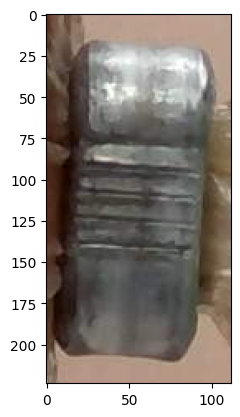

In [130]:
ret, frame = cap.read()
if not ret:
    print("Error: Could not read frame from webcam.")
image = process_frame(frame, yolo_model)
if image is None:
    print("No detection found.")
else:
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

In [131]:
os.makedirs(DATA_PATH, exist_ok=True)
pbar = tqdm(total=ROTATION_COUNT * (360 // DEGREE_PER_IMAGE), desc="Total Progress")
save_path = os.path.join(DATA_PATH, "raw_data", "rgb_2")
os.makedirs(save_path, exist_ok=True)
for rot in tqdm(range(ROTATION_COUNT), desc="Loop"):
    for d in tqdm(range(0, 360, DEGREE_PER_IMAGE), desc="Degrees", leave=False):
        pbar.update(1)
        degrees = (360*rot + d) * SAUSAGE_RATIO
        controller.rotate_to_angle(degrees, verbose=False)
        ret, frame = cap.read()
        image = process_frame(frame, yolo_model)
        if image is None:
            print("No detection found.")
            continue

        cv.imwrite(os.path.join(save_path, f"image_{rot}_{d}.jpg"), image)
pbar.close()

Total Progress:   0%|          | 0/5760 [00:00<?, ?it/s]

Loop:   0%|          | 0/16 [00:00<?, ?it/s]

Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

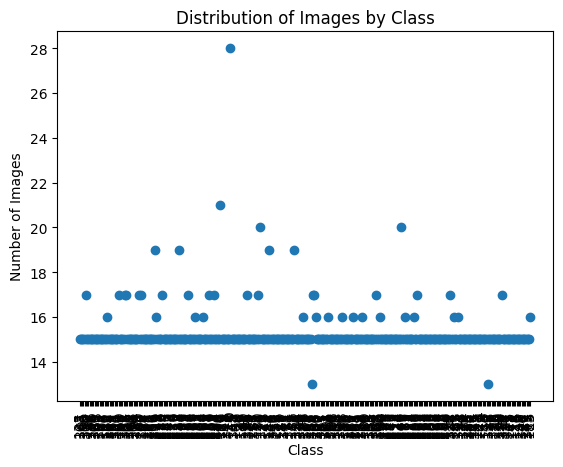

In [132]:
path = os.path.join(DATA_PATH, "by_degrees")
classes = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]

# Count the number of images in each class
class_counts = {cls: len(os.listdir(os.path.join(path, cls))) for cls in classes}

# Plot the histogram
plt.scatter(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images by Class')
plt.xticks(rotation=90)
plt.show()